In [1]:
import argparse
import datetime
import json
import random
import time
import multiprocessing
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import hotr.data.datasets as datasets
import hotr.util.misc as utils
from hotr.engine.arg_parser import get_args_parser
from hotr.data.datasets import build_dataset, get_coco_api_from_dataset
from hotr.engine.trainer import train_one_epoch
from hotr.engine import hoi_evaluator, hoi_accumulator
from hotr.models import build_model
import wandb

from hotr.util.logger import print_params, print_args

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
command='''--HOIDet \
--share_enc \
--pretrained_dec \
--num_hoi_queries 16 \
--object_threshold 0 \
--temperature 0.05 \
--no_aux_loss \
--eval \
--dataset_file vcoco \
--data_path /gemini/code/v-coco \
--resume /gemini/code/hotr/checkpoints/vcoco/MMH_vcoco_pos_scaler/vcoco_multi_run/best.pth \
--use_pos_info \
--pos_scaler_type scaler \
--batch_size 1
'''
command=command.strip().split(' ')

In [2]:
command='''--HOIDet \
--share_enc \
--pretrained_dec \
--num_hoi_queries 16 \
--object_threshold 0 \
--temperature 0.05 \
--no_aux_loss \
--eval \
--dataset_file vcoco \
--data_path /gemini/code/v-coco \
--resume /gemini/code/hotr/checkpoints/vcoco/MMH/vcoco_multi_run_no_use_pos_info/best.pth \
--batch_size 1
'''
command=command.strip().split(' ')

In [3]:
parser = argparse.ArgumentParser(
    'End-to-End Human Object Interaction training and evaluation script',
    parents=[get_args_parser()]
)

args = parser.parse_args(args=command)

In [4]:
utils.init_distributed_mode(args)

if args.frozen_weights is not None:
    print("Freeze weights for detector")

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Not using distributed mode


In [5]:
# Data Setup
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val' if not args.eval else 'test', args=args)
assert dataset_train.num_action() == dataset_val.num_action(), "Number of actions should be the same between splits"
args.num_classes = dataset_train.num_category()
args.num_actions = dataset_train.num_action()
args.action_names = dataset_train.get_actions()
if args.share_enc: args.hoi_enc_layers = args.enc_layers
if args.pretrained_dec: args.hoi_dec_layers = args.dec_layers
if args.dataset_file == 'vcoco':
    # Save V-COCO dataset statistics
    # 这里有动作的重要参数
    args.valid_ids = np.array(dataset_train.get_object_label_idx()).nonzero()[0]
    args.invalid_ids = np.argwhere(np.array(dataset_train.get_object_label_idx()) == 0).squeeze(1)
    args.human_actions = dataset_train.get_human_action()
    args.object_actions = dataset_train.get_object_action()
    args.num_human_act = dataset_train.num_human_act()
# elif args.dataset_file == 'hico-det':
#     args.valid_obj_ids = dataset_train.get_valid_obj_ids()
print_args(args)

sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

# data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
#                                collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

loading annotations into memory...
Done (t=1.65s)
creating index...
index created!
loading annotations into memory...
Done (t=1.57s)
creating index...
index created!

[Logger] DETR Arguments:
	lr: 0.0001
	lr_backbone: 1e-05
	lr_drop: 80
	frozen_weights: None
	backbone: resnet50
	dilation: False
	position_embedding: sine
	enc_layers: 6
	dec_layers: 6
	num_queries: 100
	dataset_file: vcoco

[Logger] DETR_HOI Arguments:
	hoi_dec_layers: 6
	hoi_nheads: 8
	hoi_dim_feedforward: 2048
	hoi_idx_loss_coef: 1
	hoi_act_loss_coef: 1
	hoi_eos_coef: 0.1
	object_threshold: 0.0


In [6]:
# Model Setup
model, criterion, postprocessors = build_model(args)
model.to(device)

model_without_ddp = model
if args.distributed:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
    model_without_ddp = model.module
n_parameters = print_params(model)

param_dicts = [
    {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": args.lr_backbone,
    },
]


[Logger] Number of params:  51576960


In [7]:
# Weight Setup
if args.frozen_weights is not None:
    if args.frozen_weights.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.frozen_weights, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
    model_without_ddp.detr.load_state_dict(checkpoint['model'])

if args.resume:
    if args.resume.startswith('https'):
        checkpoint = torch.hub.load_state_dict_from_url(
            args.resume, map_location='cpu', check_hash=True)
    else:
        checkpoint = torch.load(args.resume, map_location='cpu')
    model_without_ddp.load_state_dict(checkpoint['model'])

In [8]:
import os
import torch
import time
import datetime

import hotr.util.misc as utils
import hotr.util.logger as loggers
from hotr.data.evaluators.vcoco_eval import VCocoEvaluator
from hotr.util.box_ops import rescale_bboxes, rescale_pairs

In [9]:
model.eval()
criterion.eval()
metric_logger = loggers.MetricLogger(mode="test", delimiter="  ")
header = 'Evaluation Inference (V-COCO)'

print_freq = 1  # len(data_loader)
res = {}
hoi_recognition_time = []
def process_target(targets, target_sizes):
    for idx, (target, target_size) in enumerate(zip(targets, target_sizes)):
        labels = target['labels']
        valid_boxes_inds = (labels > 0)

        targets[idx]['boxes'] = rescale_bboxes(target['boxes'], target_size) # boxes
        targets[idx]['pair_boxes'] = rescale_pairs(target['pair_boxes'], target_size) # pairs

    return targets
def box_cxcywh_xyxy(box):
    "dimension of box is [batch_size, n, 4]"
    x1 = box[..., 0] - box[..., 2] / 2
    y1 = box[..., 1] - box[..., 3] / 2
    x2 = box[..., 0] + box[..., 2] / 2
    y2 = box[..., 1] + box[..., 3] / 2
    return np.stack([x1, y1, x2, y2], axis=-1)
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标
    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[2], box1[3]
    # 计算box1的面积
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[2], box2[3]
    # 计算box2的面积
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)

    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou
def nms(bboxes, scores, score_thresh=0.01, nms_thresh=0.45):
    """
    nms
    """
    bboxes=box_cxcywh_xyxy(bboxes)
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds) > 0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        # if score of the box is less than score_thresh, just drop it
        if cur_score < score_thresh:
            break

        keep = True
        for ind in keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box, remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]

    return np.array(keep_inds)

In [10]:
import cv2
def generate_target_image(samples,targets):
    img_id=str(list(targets[0]['image_id'].cpu().numpy())[0])
    img_id='0'*(12-len(img_id))+img_id
    img_path='/gemini/code/v-coco/coco/images/val2014/COCO_val2014_'+img_id+'.jpg'
    image=cv2.imread(img_path)
    # 获取标注
    boxes=targets[0]['boxes'].cpu().numpy()
    labels=targets[0]['labels'].cpu().numpy()
    # 标注人与物
    for i,(x1,y1,x2,y2) in enumerate(boxes.astype(np.int32)):
        print(x1,y1,x2,y2)
        if labels[i]==1:
            cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
        else:
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),2)
    # 标注关系
    pair_boxes=targets[0]['pair_boxes'].cpu().numpy()
    pair_actions=targets[0]['pair_actions'].cpu().numpy()
    pair_targets=targets[0]['pair_targets'].cpu().numpy()
    for i,(x1,y1,x2,y2,x3,y3,x4,y4) in enumerate(pair_boxes.astype(np.int32)):
        if pair_targets[i]==-1:
            cy=(y1+y2)//2
            cx=x2
            cv2.putText(image,'action name',(cx,cy),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        else:
            cx1=(x1+x2)/2
            cy1=(y1+y2)/2
            cx2=(x3+x4)/2
            cy2=(y3+y4)/2
            cx=(cx1+cx2)/2
            cy=(cy1+cy2)/2
            cv2.line(image, (cx1, cy1), (cx2, cy2), (0, 125, 0), 5)
            cv2.putText(image,'action name',(cx,cy),cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

In [11]:
def generate_result_image(samples,results,thr=0.4):
    # 获取图片
    img_id=str(list(targets[0]['image_id'].cpu().numpy())[0])
    img_id='0'*(12-len(img_id))+img_id
    img_path='/gemini/code/v-coco/coco/images/val2014/COCO_val2014_'+img_id+'.jpg'
    image=cv2.imread(img_path)
    # 获取h_box和o_box和labels
    h_box=results[0]['h_box'].cpu().numpy()
    h_score=results[0]['h_cat'].cpu().numpy()
    o_boxes=results[0]['o_box'].cpu().numpy()
    o_scores=results[0]['o_cat'].cpu().numpy()
    labels=results[0]['labels'].cpu().numpy()
    # 使用NMS进行抑制
    # 1. 对人的框进行抑制
    h_idx=nms(h_box,h_score,0.9,0.5)
    # 2. 对物体的框进行抑制
    res_idx=[]
    o_boxes=o_boxes[:100]
    for label in set(labels):
        idx=np.where(labels==label)[0]
        o_box=o_boxes[idx]
        o_score=o_scores[idx]
        keep_inds=nms(o_box,o_score,0.9,0.5)
        if len(keep_inds)<1:continue
        res_idx.extend(list(idx[keep_inds]))
    o_idx=res_idx
    # 获取NMS之后的边界框
    h_box=h_box[h_idx]
    o_boxes=o_boxes[o_idx]
    labels=labels[o_idx]
    # 绘制边界框
    # for x1,y1,x2,y2 in h_box.astype(np.int32):
    #     cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
    # for i,(x1,y1,x2,y2) in enumerate(o_boxes.astype(np.int32)):
    #     if labels[i]!=1:
    #         cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),2)

    # 获取被处理过的pair_score
    pair_score=results[0]['pair_score'].cpu().numpy()
    pair_score=pair_score[:,:,o_idx]
    pair_score=pair_score[:,h_idx,:]
    # 获取其中大于0的位置
    pair_idx=np.where(pair_score.sum(0)>0)
    act_list=dataset_val.act_list
    text_info={}
    for h,o in zip(pair_idx[0],pair_idx[1]):
        if labels[o]==1:continue
        act_score=pair_score[:,h,o]
        act_max3=np.argsort(act_score)[-3:]
        act_idx=[]
        for i in act_max3:
            if act_score[i]>thr:
                act_idx.append(i)
        if act_idx==[]:continue
        # 寻找中心点的连线
        x1,y1,x2,y2=map(int,h_box[h])
        cv2.rectangle(image,(x1,y1),(x2,y2),(255,0,0),2)
        # 收集文字描述
        offset=20
        for i,idx in enumerate(act_idx):
            name=' '.join(act_list[idx].split('_')[:-1])
            score=act_score[idx]
            text=name+','+"%0.2f"%score
            if text_info.get((x1,y1),' ')==' ':
                text_info[(x1,y1)]=[text]
            else:
                text_info[(x1,y1)].append(text)
            # cv2.putText(image,text,(x1,y1+15+i*offset),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        xh,yh=(x1+x2)/2,(y1+y2)/2
        x1,y1,x2,y2=map(int,o_boxes[o])
        cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),2)
        xo,yo=(x1+x2)/2,(y1+y2)/2
        cx,cy=(xh+xo)/2,(yh+yo)/2
        xh,yh,xo,yo,cx,cy=map(int,[xh,yh,xo,yo,cx,cy])
        # 绘制直线连接
        cv2.line(image, (xh, yh), (xo, yo), (0, 255, 0), 3)
    # 绘制文字描述
    for (x1,y1),text_list in text_info.items():
        for i,text in enumerate(text_list):
            cv2.putText(image,text,(x1,y1+15+i*20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image,img_id

In [12]:
data_loader=data_loader_val
thr=0
cnt=0
for samples, targets in metric_logger.log_every(data_loader, print_freq, header):
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    outputs = model(samples)
    loss_dict = criterion(outputs, targets)
    loss_dict_reduced = utils.reduce_dict(loss_dict)  # ddp gathering

    orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
    results = postprocessors['hoi'](outputs, orig_target_sizes, threshold=thr, dataset='vcoco')
    targets = process_target(targets, orig_target_sizes)
    hoi_recognition_time.append(results[0]['hoi_recognition_time'] * 1000)
    res.update(
        {target['image_id'].item(): \
             {'target': target, 'prediction': output} for target, output in zip(targets, results)
         }
    )
    cnt+=1
    image,img_id=generate_result_image(samples,results)
    save_path='./visual/hotr/'+img_id+'.jpg'
    cv2.imwrite(save_path,image)
    if cnt==100:
        break

2023-05-02 16:19:11 [ERROR] [ -4280403,Out of memory ] cuMemAlloc(): fail to allocate 61440 KB memory (out of memory)


In [193]:
image=generate_result_image(samples,results)

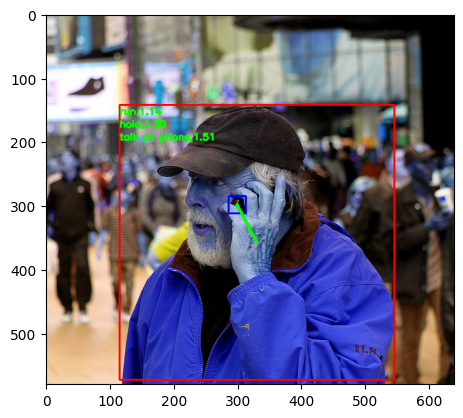

In [233]:
# 使用NMS进行人和物的去掉
h_box=results[1]['h_box'].cpu().numpy()
h_score=results[1]['h_cat'].cpu().numpy()
o_boxes=results[1]['o_box'].cpu().numpy()
o_scores=results[1]['o_cat'].cpu().numpy()
labels=results[1]['labels'].cpu().numpy()

h_ind=nms(h_box,h_score,0.9,0.5)

res_ind=[]
o_boxes=o_boxes[:100]

for label in set(labels):
    idx=np.where(labels==label)[0]
    o_box=o_boxes[idx]
    o_score=o_scores[idx]
    keep_inds=nms(o_box,o_score,0.9,0.5)
    if len(keep_inds)<1:continue
    res_ind.extend(list(idx[keep_inds]))
o_ind=res_ind
    
h_box,h_score=h_box[h_ind],h_score[h_ind]
o_box,o_score,labels=o_boxes[o_ind],o_boxes[o_ind],labels[o_ind]

In [19]:
outputs['pred_actions'].shape

torch.Size([1, 16, 30])

In [40]:
targets[0]['inst_actions'].shape

torch.Size([6, 51])

In [25]:
pair_score=results[0]['pair_score'].cpu().numpy()
pair_score.shape

(29, 4, 101)

In [30]:
np.where(pair_score[0,:,:]>0)

(array([1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3]),
 array([ 31,  72,  98, 100,  31,  72,  98,  10,  61,  71,  72, 100]))

In [14]:
dataset_val.act_list

['hold_obj',
 'stand_agent',
 'sit_instr',
 'ride_instr',
 'walk_agent',
 'look_obj',
 'hit_instr',
 'hit_obj',
 'eat_obj',
 'eat_instr',
 'jump_instr',
 'lay_instr',
 'talk_on_phone_instr',
 'carry_obj',
 'throw_obj',
 'catch_obj',
 'cut_instr',
 'cut_obj',
 'run_agent',
 'work_on_computer_instr',
 'ski_instr',
 'surf_instr',
 'skateboard_instr',
 'smile_agent',
 'drink_instr',
 'kick_obj',
 'point_instr',
 'read_obj',
 'snowboard_instr']